In [1]:
!pip install pymoo

####  Part 3: Assume that the plant is operating on 1st January 2018. From the predicted price and other parameters (given in Details section), optimise the electricity procurement costs along with its environmental impact (in terms of Carbon Footprint) while ensuring a minimum of 20% renewable electricity utilisation in its energy mix and report the following optimised quantities for the plant:

    a) Optimised Percentage of the Total Renewable Electricity out of the Total Electricity 
    b) Optimised Quantity of Electricity to be drawn from the State Electricity Grid 
    c) Optimised Quantity of Electricity to be drawn from the Power Exchange

* Carbon footprint:907.18
a) Optimised Percentage of Total Renewable Electricity of Total Electricity: 20.43%
b) Optimised Quantity of Electricity drawn from State Electricity Grid on 1st January 2018 (Quant_Grid): 426.55 MWh
c) Optimised Quantity of Electricity drawn from the Power Exchange on 1st January 2018 (Quant_Exchange): 623.53 MWh


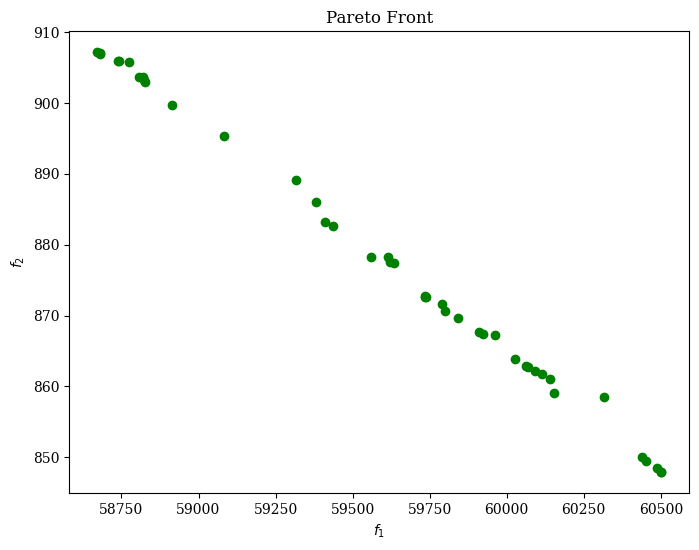

In [8]:
import numpy as np
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2 #using non-dominant sorting genetic algorithm
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Electricity_Optimization(Problem):
    def __init__(self, exchange_costs):
        super().__init__(n_var=2, n_obj=2, n_constr=2, xl=np.array([0, 0]), xu=np.array([1050, 1050]))
        #upper bound as 1050 because 150 MWhr/day is procured from captive solar power plant
        self.exchange_costs = exchange_costs

    def _evaluate(self, x, out, *args, **kwargs):
        # Fixed Parameters
        total_demand= 1200 # MWh/Day
        Quant_solar = 150  # MWh/Day
        cost_grid = 57.62  # EUR/MWh per day
        carbon_footprint = 0.95  # MTCO2e/MWh

        # Decision Variables
        Quant_grid = x[:, 0]
        Quant_exchange = x[:, 1]

        # To get the exchange costs for a current date (we take 1st january 2018)
        current_date_index = kwargs.get("current_date_index",1)
        current_date = list(self.exchange_costs.keys())[current_date_index]
        exchange_cost = self.exchange_costs[current_date]

        # Objective functions
        total_cost_grid = Quant_grid * cost_grid
        total_cost_exchange = Quant_exchange * exchange_cost
        grandtotal_cost = total_cost_grid + total_cost_exchange
        total_carbon_footprint =((0.85 * Quant_grid) + (0.95 * Quant_exchange)) * carbon_footprint

        out["F"] = np.column_stack([grandtotal_cost, total_carbon_footprint])

        # Constraints
        out["G"] = np.column_stack([total_demand - (Quant_grid + Quant_exchange + Quant_solar),  # Demand constraint
                                    0.20 * total_demand - ((0.15 * Quant_grid) + (0.05 * Quant_exchange) + Quant_solar)]) 
                                   #renewable share constraint
            
# Reading the excel file for exchange electricity procurement cost for year 2018        
exchange_costs_df = pd.read_excel("Power Exchange Data_2018.xlsx")
exchange_costs_dict = exchange_costs_df.set_index('Date')['Prices (EUR/MWh)'].to_dict()

# Create the problem instance with exchange costs
problem = Electricity_Optimization(exchange_costs=exchange_costs_dict)

# Defining the algorithm
algorithm = NSGA2(pop_size=100)

# Defining the optimization
res = minimize(problem, algorithm, ('n_gen', 100), seed=1, verbose=False)

# Extracting the optimized solution
distances = np.sqrt(np.sum(res.F**2, axis=1)) #Euclidean distance from both the variables for 365 days
optimal_solution_index = np.argmin(distances) # Opting the solution with minimum cost and minimum carbon footprint
optimal_solution = np.clip(res.X[optimal_solution_index], [0, 0], [1050, 1050])  # Ensuring values are within bounds for both variables

# Extract the optimized quantities
Quant_grid_optimized, Quant_exchange_optimized = optimal_solution

# Calculate the total renewable electricity
Quant_solar = 150  # MWh/Day
total_renewable = (0.15 * Quant_grid_optimized) + (0.05 * Quant_exchange_optimized) + Quant_solar  

# Calculating the percentage of carbon footprint, total renewable electricity of total electricity
carbon_footprint = 0.95
total_carbon_footprint=((0.85 * Quant_grid_optimized) + (0.95 * Quant_exchange_optimized)) * carbon_footprint
percentage_renewable = (total_renewable / (Quant_grid_optimized + Quant_exchange_optimized + Quant_solar)) * 100

# Displaying the results
print("* Carbon footprint:{:.2f}".format(total_carbon_footprint))
print("a) Optimised Percentage of Total Renewable Electricity of Total Electricity: {:.2f}%".format(percentage_renewable))
print("b) Optimised Quantity of Electricity drawn from State Electricity Grid on 1st January 2018 (Quant_Grid): {:.2f} MWh".format(Quant_grid_optimized))
print("c) Optimised Quantity of Electricity drawn from the Power Exchange on 1st January 2018 (Quant_Exchange): {:.2f} MWh".format(Quant_exchange_optimized))


# Plotting the pareto front graph for that particular day
plot = Scatter(title="Pareto Front")
plot.add(res.F, color="green", label="Optimized Solutions")
plot.show()

In [9]:
exchange_costs_df

,Unnamed: 0,Date,Prices (EUR/MWh)
0,0,2018-01-01,54.013573
1,1,2018-01-02,54.679552
2,2,2018-01-03,65.955168
3,3,2018-01-04,65.817036
4,4,2018-01-05,60.317153
...,...,...,...
360,360,2018-12-27,33.204243
361,361,2018-12-28,36.104304
362,362,2018-12-29,31.379290
363,363,2018-12-30,25.881253
